Cardinality Analysis
===

This whole notebook was to diagnose a data error during analysis.  The bug in the data-loading process was fixed and models were retrained with the correct data.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
import os

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib

from collections import Counter

In [3]:
import sys
sys.path.append("../annotation_data")

In [4]:
import responsibility as responsibility_utils

In [5]:
from importlib import reload
responsibility_utils = reload(responsibility_utils)

In [23]:
# load the test predictions
vw_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/classification/responsibilities/vw"
all_preds_filepath = os.path.join(vw_working_dir, "vw_all_preds.pkl")
df = pd.read_pickle(all_preds_filepath)
len(df)

157389

In [7]:
[col for col in df.columns if not col.endswith("_score") and not col.endswith("_pred_label")]

['conflict_status',
 'index',
 'is_annotated',
 'journal_oid',
 'responsibilities',
 'site_id',
 'behavior_changes_pred',
 'compliance_pred',
 'coordinating_support_pred',
 'financial_management_pred',
 'giving_back_pred',
 'sharing_medical_info_pred',
 'coordinating_support_label',
 'sharing_medical_info_label',
 'compliance_label',
 'financial_management_label',
 'giving_back_label',
 'behavior_changes_label',
 'journal_text_length']

In [24]:
pred_label_cols = [col for col in df.columns if col.endswith("_pred_label")]
df['pred_cardinality'] = df.apply(lambda row: np.sum(row[pred_label_cols] == 1), axis=1)

In [25]:
label_cols = [col for col in df.columns if col.endswith("_label") and not col.endswith("_pred_label")]
df['annotated_cardinality'] = df.apply(lambda row: np.sum(row[label_cols] == 1) if row.is_annotated else -1, axis=1)

In [10]:
Counter(df.is_annotated).most_common()

[(False, 155494), (True, 1895)]

In [11]:
annotated_df = responsibility_utils.get_responsibility_annotations_dataframe()
len(annotated_df)

1913

In [17]:
annotated_df['cardinality'] = annotated_df.responsibilities.map(lambda resp_list: len([1 for resp in responsibility_utils.high_irr_responsibility_labels if resp in resp_list]))

In [13]:
annotated_df.head()

,conflict_status,journal_oid,responsibilities,site_id,cardinality
0,SINGLE USER,51be14196ca004193500934e,[],106710,0
1,SINGLE USER,51be14196ca0041935009526,[],106710,0
2,SINGLE USER,51be14196ca0041935009660,"[sharing_medical_info, compliance]",106710,2
3,SINGLE USER,51be14196ca00419350098b4,[coordinating_support],106710,1
4,SINGLE USER,51be14196ca00419350099e0,"[sharing_medical_info, compliance]",106710,2


In [14]:
Counter(annotated_df.conflict_status).most_common()

[('CONFLICT', 1039), ('SINGLE USER', 867), ('RESOLVED', 7)]

In [15]:
Counter(annotated_df.responsibilities.map(lambda resp_list: tuple(resp_list))).most_common()[:10]

[(('sharing_medical_info', 'compliance'), 313),
 (('symptom_management', 'sharing_medical_info', 'compliance'), 175),
 (('preparation', 'sharing_medical_info', 'compliance'), 106),
 (('sharing_medical_info', 'compliance', 'managing_transitions'), 81),
 ((), 75),
 (('sharing_medical_info',), 58),
 (('symptom_management',
   'sharing_medical_info',
   'compliance',
   'managing_transitions'),
  53),
 (('coordinating_support', 'sharing_medical_info', 'compliance'), 52),
 (('symptom_management', 'sharing_medical_info'), 52),
 (('unknown',), 46)]

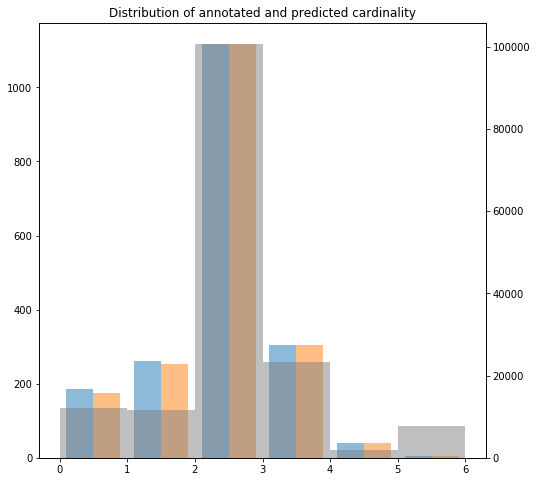

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
bins = range(0,7)
ax.hist([annotated_df.cardinality, df.annotated_cardinality], bins=bins, alpha=0.5)
ax2 = ax.twinx()
ax2.hist(df.pred_cardinality, bins=bins, color='gray', alpha=0.5)
plt.title("Distribution of annotated and predicted cardinality")
plt.show()

The plot above indicates that the data used to train the responsibilities model was incorrect. In particular, it included far fewer cases where 3, 4, or 5 labels were assigned to a training instance.
The predicted distribution pretty closely adheres to the incorrect distribution, which suggests it could achieve a more acccurate distribution if it were trained on the correct data.
A clear takeaway from this evidence is that we must retrain the responsibilities model with the correct data.


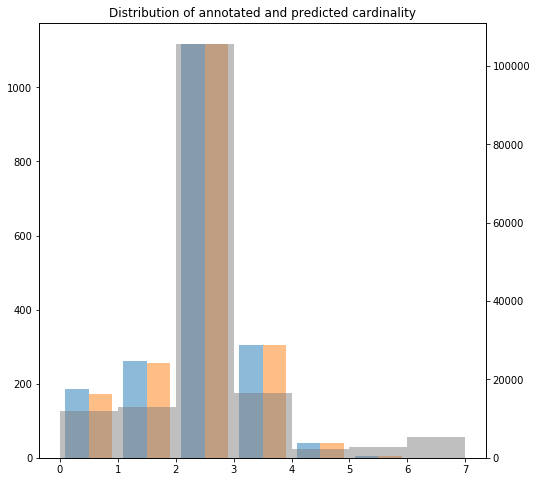

In [37]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
bins = range(0,8)
ax.hist([annotated_df.cardinality, df.annotated_cardinality], bins=bins, alpha=0.5)
ax2 = ax.twinx()
ax2.hist(df.pred_cardinality, bins=bins, color='gray', alpha=0.5)
plt.title("Distribution of annotated and predicted cardinality")
plt.show()

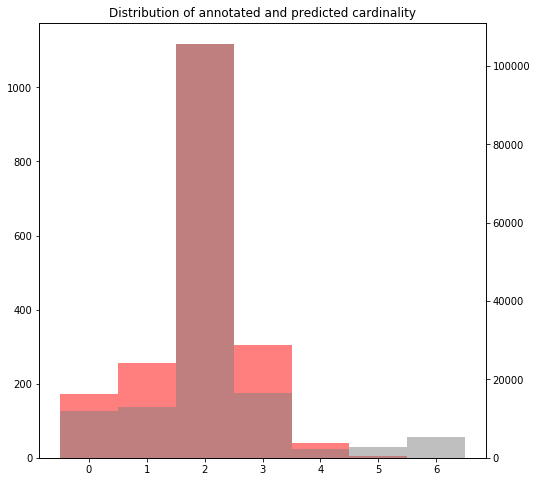

In [35]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
bins = range(0,8)
ax.hist(df.annotated_cardinality, bins=bins, color='red', alpha=0.5, align='left')
ax2 = ax.twinx()
ax2.hist(df.pred_cardinality, bins=bins, color='gray', alpha=0.5, align='left')
plt.title("Distribution of annotated and predicted cardinality")
plt.show()